# Assignment 1

**Group 22**

A. Siganos ( 1283871 )     
J. Gómez Robles ( 1286552 )

**General remarks**

For this notebook, it is importat to run the first 3 blocks (libraries, text processing and util functions) to be able to execute the different tasks. The work is presented in the order of the original questions and some labels were added to ease the reading. Additionally, comments were also added in the code to explain the purpose of each cell.

Please note that the output cells in the notebook already contain results that are used for some of the discussions.


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

Using TensorFlow backend.


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix


# 0. Util functions

In [3]:
################################################################################
############################## 0. Util functions ###############################
################################################################################

import math
import pickle # To save objects into files

# This is used for plotting
import operator

# To measure running times
import time

# Plotting
import matplotlib.pyplot as plt

# Only for the word2vec parsing of last exercise (loading word2vec with gensim was part of the initial template)
# It is not used anywhere
import gensim

# Get the word_index from the tokenizer to make it accessible for all cells below.
full_index = tokenizer.word_index

def getLabels(index, includeZero = False):
    """This function returns the labels of all the vocabulary, ordered by index. This is needed
    because of the original representation of the word_index (word, index)
    """
    
    # Sort labels by second entry (index of the word)
    sorted_labels = sorted(index.items(), key=operator.itemgetter(1))
    # We are working with sizeOfVocabulary + 1, hence we decide to include zero (empty row) if requested.
    if includeZero :
        sorted_labels.insert(0, ('', 0))
    # Just get the words (labels)
    labels_only = [i[0] for i in sorted_labels]
    return np.asarray(labels_only)


def getAnalogyWords():
    """This methods reads the analogy file and returns a list of all the words appearing in it. 
    Duplicates are not handled.
    """
    
    content = []
    
    # Read file
    with open("analogy_alice.txt") as f:
        content = f.readlines()

    # Remove whitespace characters like '\n' at the end of each line
    content = [x.strip() for x in content] 

    # Read all words of length 4 (valid analogy) and store them
    wordsSubset = []
    for analogy in content:
        words = analogy.split(" ")
        if len(words) == 4:
            wordsSubset.append(words[0])
            wordsSubset.append(words[1])
            wordsSubset.append(words[2])
            wordsSubset.append(words[3])
    return wordsSubset


def getKeyFromValue(dictionary, target):
    """This function returns the key, given a value in the dictonary.
    """
    
    return list(dictionary.keys())[list(dictionary.values()).index(target)]


def plot_embedding(x, labels, labelsIntersect, title):
    """This function plots the first two columns of a matrix (weights matrix) and 
    adds annotations from the labels argument only if they exist in the labelsIntersect list.
    For our problem, it helps to annotate the words in the analogy task only.
    """
    
    # The get min and max of each axis to be able to plot with the correct dimensions.
    x0Max = max(x[:, 0])
    x1Max = max(x[:, 1])
    x0Min = min(x[:, 0])
    x1Min = min(x[:, 1])

    x1Size = x1Max - x1Min
    x0Size = x0Max - x0Min
    
    # Make the plot of the points 
    fig,ax = plt.subplots()
    fig.set_size_inches(15, (x1Size/x0Size)*15)
    plt.title(title, fontsize=20)
    plt.scatter(x[:,0], x[:,1], s = 5)
    
    # Put the annotations
    for i in range(len(labels)):
        if( labels[i] in labelsIntersect):
            plt.annotate(labels[i],
                     xy=(x[i,0], x[i,1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
def saveObject(obj, filename):
    pickle.dump( obj, open( filename, "wb" ) )

def loadObject(filename):
    return pickle.load( open( filename, "rb" ) )

CBOW_WEIGHTS_FILE = "cbow.pkl"
SG_WEIGHTS_FILE = "skipgram.pkl"
CBOW_HIDDEN_WEIGHTS_FILE = "cbow_hidden.pkl"
SG_HIDDEN_WEIGHTS_FILE = "skipgram_hidden.pkl"

EMBEDDING_TYPE_1 = "weightedMatrix"
EMBEDDING_TYPE_2 = "word2vec"



In [5]:
# Optionally Load saved objects. We opted for this to ease persistance.

cbowWeights = loadObject(CBOW_WEIGHTS_FILE)
skipgramWeights = loadObject(SG_WEIGHTS_FILE)
cbowHiddenLayerWeights = loadObject(CBOW_HIDDEN_WEIGHTS_FILE)
skipgramHiddenLayerWeights= loadObject(SG_HIDDEN_WEIGHTS_FILE)



## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


#### 1. Implement word-word co-ocurrence matrix / 2. Normalize the words such that every value lies within a range of 0 and 1

In [79]:
################################################################################
################# 1. Implement word-word co-ocurrence matrix ###################
################################################################################

# Create my co-ocurrence matrix, initially 0 (VxV size)
# How to access this matrix:
#   Each column is an (index - 1) (column 0 is word in index 1; column 1 is word in index 2; ...)
wcoMatrix = np.zeros([V, V]) 

# Using my window_size_corpus to define my context scope
scope = window_size_corpus

# Greedy approach. For each line in the corpus. 
for s in corpus:
    # For each word
    for current_index in range(0, len(s)):
        current_value = s[current_index] # Get the 'word'
        # From left to right
        for neighbor_index in range(current_index - scope, current_index + scope + 1):
            # Never out of boundaries and never the same index
            if ( neighbor_index >= 0 and neighbor_index < len(s) ) and ( neighbor_index != current_index ):
                # Get my neighbor 'word'
                neighbor = s[neighbor_index] 
                # Never myself and myself (keeping diagonal to 0)
                if current_value != neighbor:
                    # Update the ocurrence
                    wcoMatrix[current_value, neighbor] += 1
                    
################################################################################
################################# 2. Normalize #################################
################################################################################
wcoMatrix = wcoMatrix / wcoMatrix.max()
wcoMatrix

# Print a summary of the matrix
print("Sumary of the word-word co-ocurrence matrix")
print(" - Shape", wcoMatrix.shape)
print(" - Min value", wcoMatrix.min())
print(" - Max value", wcoMatrix.max())


Sumary of the word-word co-ocurrence matrix
 - Shape (1183, 1183)
 - Min value 0.0
 - Max value 1.0


#### 3. Compute the cosine distance between the given words

In [72]:
################################################################################
########### 3. Compute cosine similarity to Alice, Dinah and Rabbit ############
################################################################################

words_to_compare = ["Alice", "Dinah", "Rabbit"]

wcoMatrix

# Iterate on all possible combinations
for w1 in words_to_compare:
    w1 = w1.lower() 
    x = full_index[w1]
    for w2 in words_to_compare:
        w2 = w2.lower()
        if w1 != w2:
            y = full_index[w2]
            # Ensure 1xV vectors
            X = wcoMatrix[x, :].reshape((1, V))
            Y = wcoMatrix[y, :].reshape((1, V))
            print("cosine_similarity(%s, %s)=%s" % (w1, w2, cosine_similarity(X, Y)))
            

cosine_similarity(alice, dinah)=[[0.39360011]]
cosine_similarity(alice, rabbit)=[[0.47890931]]
cosine_similarity(dinah, alice)=[[0.39360011]]
cosine_similarity(dinah, rabbit)=[[0.29862324]]
cosine_similarity(rabbit, alice)=[[0.47890931]]
cosine_similarity(rabbit, dinah)=[[0.29862324]]


#### 4. List the 5 closest words to 'Alice'. Discuss the results.

In [55]:
################################################################################
################## 4a. List the 5 closest words to 'Alice'. ####################
################################################################################

################################
### We use Nearest Neighbors ###
################################

# It was not importing, so we hardcode it here...
from sklearn.neighbors import NearestNeighbors

# Define our variables
# targetWord = "Rabbit".lower()
targetWord = "Alice".lower()
X = wcoMatrix
N_NEIGHBORS = 5
# full_index = tokenizer.word_index

# Perfrom the NearestNeibhbors algorithm
nbrs = NearestNeighbors(n_neighbors = N_NEIGHBORS, metric = "cosine").fit(X)

# Get the index corresponding to the target word
aliceMatrixIndex = full_index[targetWord]

# Get results from nearest neighbors
distances, indices = nbrs.kneighbors()
aliceIndices = indices[aliceMatrixIndex, :]
aliceDistances = distances[aliceMatrixIndex, :]

# Output result
print("Nearest neighbors (co-ocurrence matrix based) to %s (index %s):" % (targetWord, aliceMatrixIndex))
for i in range(0, N_NEIGHBORS):
    print( "%s [index %s] with distance: %s" % (getKeyFromValue(full_index, aliceIndices[i]), aliceIndices[i], aliceDistances[i]) )


Nearest neighbors (co-ocurrence matrix based) to alice (index 11):
she [index 4] with distance: 0.1976485517655754
it [index 7] with distance: 0.2456543397501072
herself [index 41] with distance: 0.2703730120603708
that [index 13] with distance: 0.2748881826897964
in [index 10] with distance: 0.28125983544451916


**4b. Discuss the results**

We observe that the most similar words are pronouns and prepositions. Although these results intuitively make some sense (Alice is the main character of the book and consequently, describing her behaviour is expected), no idiomatic relations can be achieved by means of the simple word-word co-ocurrence matrix.

Note that the distance returned is not the cosine similarity, but the distance found by the algorithm, so a value close to 0 is expected (contrarely to the cosine_similarity).


**5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions? **

A co-occurence matrix requires large memory for storage especially for larger data sets, since it builds a square matrix of the size of the words in the dictionary. This implies that we fill in the matrix with information of very infrequent words that do not add any value.


## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


#### 1. CBOW

In [9]:
# prepare data for cbow
def generate_data_cbow(corpus, window_size, V):
    all_in = [] 
    all_out = []
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            if contexts != []:
                all_in.append(sequence.pad_sequences(contexts, maxlen = maxlen))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out) # return the values
            

In [10]:
#create CBOW model

def getCbowModel(dim = 50, extra_layer = False):

    # The Sequential model is a linear stack of layers.
    cbow = Sequential()
    cbow.add(Embedding(input_dim = V, output_dim = dim, input_length = window_size*2))

    if extra_layer :
        cbow.add(Dense(input_dim = V, units = dim, kernel_initializer = 'uniform', activation = 'relu'))

    cbow.add( Lambda(lambda x: K.mean(x, axis = 1), output_shape = (dim,)) )
    cbow.add( Dense(V, activation = 'softmax') )

    # define loss function for Cbow
    cbow.compile(loss='categorical_crossentropy', optimizer = 'sgd')

    return cbow


In [15]:
################################################################################
################################ Train model ###################################
################################################################################

dims = [50, 150, 300]
iterations = 10
cbowWeights = []

for dimension in dims:
    print("Running CBOW (dim = %s)..."% dimension)
    cbow = getCbowModel(dimension, False)
    X, Y = generate_data_cbow(corpus, window_size, V)
    start_time=time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X, Y):
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)

    end_time = time.time()
    
    print("--- %s seconds ---" % (end_time - start_time))
    
    cbowWeights.append(cbow.get_weights()[0])


Running CBOW (dim = 50)...
0 44601.67876148224
1 41790.07820343971
2 40461.63430213928
3 39799.229499578476
4 39377.97354865074
5 39071.69885444641
6 38831.840252161026
7 38632.122371435165
8 38455.313530921936
9 38288.82012844086
--- 90.3889229297638 seconds ---
Running CBOW (dim = 150)...
0 44591.816042900085
1 41757.18619656563
2 40415.314865112305
3 39736.39692187309
4 39292.273763656616
5 38957.2939953804
6 38682.01193833351
7 38439.058683633804
8 38211.17459821701
9 37988.654198765755
--- 165.59871101379395 seconds ---
Running CBOW (dim = 300)...
0 44572.66657114029
1 41710.2505877018
2 40360.93527841568
3 39666.56321191788
4 39197.76988840103
5 38832.850528240204
6 38523.798636198044
7 38244.17152285576
8 37978.66506791115
9 37720.96739768982
--- 298.5120062828064 seconds ---


#### 2. Skipgram

In [11]:
#prepare data for Skipgram

# This function creates a list where _each word_ in the text file (with non-empty content)
# is encoded into two arrays:
#   - x: an array of the size of all his windows_size neighbors with the value of the word (i.e, repeated values)
#   - y: an array of the same size as x pointing to each neighbor. Finally encoded in a |V|-list as one-hot enc
def generate_data_skipgram(corpus, window_size, V):
    all_in = [] 
    all_out = []
    for sentence in corpus: # For, sentence in corpus
        L = len(sentence) # Limit for the iteration (per sentence)

        # For each pair in the index
        for index, word in enumerate(sentence):
            # Create X and Y
            in_words = [] # list of lists
            labels = [] # list of integers

            # Iterate over all the sentence, for each word in the line. I.e, for each word:
            for i in range(index - window_size, index + window_size + 1):
                # If between the limits and not myself
                if i != index and (0 <= i < L):
                    # This means: Associating the words in my neighbor (context) 
                    in_words.append([word]) # Current word (as a list) is associated to...
                    labels.append(sentence[i]) # ... this word (as a simple integer).
                    
            # Once I have saved the context for the current word...
            # ... if there is something in the arrays
            if in_words != []:
                # Save the information to the all_in/out arrays
                all_in.append(np.array(in_words,dtype=np.int32)) # X in integer format
                # Set Y to categorical values. If my output is ([6, 26]). Then I create
                # a vector from 0 to V and mark 6 and 26 as 1
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out) # return the values



In [12]:
# create Skipgram model
import tensorflow as tf
from keras.layers import Activation

def getSkipgramModel(dim = 50, extra_layer = False):

    # The Sequential model is a linear stack of layers.
    skipgram = Sequential()
    
    # First layer (Projection layer. Embedding for wt)
    # 
    # Parameters: 
    #   - input_dim: V (From the book: 1xV (input layer))
    #   - embeddings_initializer = Glorot uniform. Is it for the uniform distribution of the noises?
    #   - input_length: 1. It is needed for the dense layer (https://keras.io/layers/embeddings/#embedding)
    skipgram.add( Embedding(input_dim = V, output_dim = dim, embeddings_initializer = 'glorot_uniform', input_length = 1) )

    # Intermediate layer. Can be seen as a helper only.
    skipgram.add( Reshape((dim, )) )

    
    # Extra layer
    if extra_layer :
        skipgram.add(Dense(input_dim = dim, units = V, kernel_initializer = 'uniform', activation = "relu"))

    # Last Layer (Output layer. Probabilities of context words)
    # From documentation, Dense implements the operation: 
    #      output = activation(dot(input, kernel) + bias) 
    #   where:
    #      activation is the element-wise activation function passed as the activation argument
    #      kernel is a weights matrix created by the layer
    #      and bias is a bias vector created by the layer (only applicable if use_bias is True). _WE DO NOT SET THIS_.
    #
    #
    # Parameters:
    #   - input_dim: dim. From embedding layer, dx1
    #   - units: V. The output dimension, From the book 1xV
    #   - kernel_initializer: uniform (?)
    #   - activation: softmax (as described in the book)

    skipgram.add( Dense(input_dim = dim, units = V, kernel_initializer = 'uniform', activation = 'softmax') )
    
    
    # define loss function for Skipgram
    skipgram.compile(loss='categorical_crossentropy', optimizer='sgd')

    return skipgram

In [13]:
################################################################################
############################ Train Skipgram model ##############################
################################################################################

dims = [50, 150, 300]
iterations = 10
skipgramWeights = []

for dimension in dims:
    print("Running Skipgram (dim = %s)..."% dimension)
    skipgram = getSkipgramModel(dimension, False)
    X, Y = generate_data_skipgram(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()
    
    print("--- %s seconds ---" % (end_time - start_time))
    
    skipgramWeights.append(skipgram.get_weights()[0])


Running Skipgram (dim = 50)...
0 44421.626368522644
1 41564.82498836517
2 40222.562515735626
3 39551.70948576927
4 39123.58237814903
5 38811.87125682831
6 38568.377737760544
7 38368.59377813339
8 38199.022907972336
9 38051.59983921051
--- 133.20652222633362 seconds ---
Running Skipgram (dim = 150)...
0 44416.98604488373
1 41548.49153089523
2 40195.420374155045
3 39510.188039302826
4 39063.86323881149
5 38730.744644880295
6 38464.030099630356
7 38240.71227812767
8 38047.5455801487
9 37875.430398225784
--- 209.91901683807373 seconds ---
Running Skipgram (dim = 300)...
0 44411.07230424881
1 41525.08709025383
2 40155.286662817
3 39450.08147644997
4 38981.01269412041
5 38624.27298498154
6 38334.91655731201
7 38090.437779188156
8 37876.82333660126
9 37684.24890136719
--- 362.54384684562683 seconds ---


#### 3. Add extra hidden dense


##### Justification for the selected hidden layer

To determine which activation function to use for the extra hidden layer first we tried a number of different functions like 'sigmoid' 'linear' 'relu' etc. Out of all 10 possible activation functions relu was one of the best performants in terms of loss, meaning that it was among the lowests. Additionaly, the selection of relu is justified by the fact that the actual function takes in account only positive "probabilities" of the neurons since it serves as a thresholded at zero. This led in a signficantly better performance in time, especially compared to other functions. Finally since we also used SGD as our optimizer picking relu makes even more sence since it has been found  to accelerate the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. It is argued that this is due to its linear, non-saturating form in 'ImageNet Classification with Deep Convolutional Neural Networks' paper 
(http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

##### a. CBOW additional hidden layer

In [16]:
################################################################################
##################### 3. Using CBOW model (extra layer) ########################
################################################################################

dims = [50, 150, 300]
iterations = 7 # Less iterations for the sake of time
cbowHiddenLayerWeights = []

for dimension in dims:
    print("Running CBOW with hidden layer (dim = %s)..."% (dimension))
    cbow = getCbowModel(dimension, True)
    X, Y = generate_data_cbow(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()

    print("--- %s seconds ---" % (end_time - start_time))

    cbowHiddenLayerWeights.append(cbow.get_weights()[0])


Running CBOW with hidden layer (dim = 50)...
0 42634.35505056381
1 38497.09729504585
2 38198.34133911133
3 38112.94175553322
4 38057.29005861282
5 38003.22901892662
6 37937.873049497604
--- 76.4930031299591 seconds ---
Running CBOW with hidden layer (dim = 150)...
0 42187.37550282478
1 38443.555738925934
2 38182.643315553665
3 38086.34499120712
4 38002.92841887474
5 37905.124784231186
6 37783.69950675964
--- 126.3455228805542 seconds ---
Running CBOW with hidden layer (dim = 300)...
0 41737.87182664871
1 38390.27683186531
2 38151.64488863945
3 38031.79694533348
4 37903.76432776451
5 37744.034385085106
6 37559.92156851292
--- 242.60364866256714 seconds ---


###### b. Skipgram additional hidden layer

In [18]:
################################################################################
################### 3. Using Skipgram model (extra layer) ######################
################################################################################

dims = [50, 150, 300]
iterations = 3 # Less iterations for the sake of time
skipgramHiddenLayerWeights = []

for dimension in dims:
    print("Running Skipgram with hidden layer (dim = %s)..."% (dimension))
    # set extra_layer = true
    skipgram = getSkipgramModel(dimension, True)
    X, Y = generate_data_skipgram(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()

    print("--- %s seconds ---" % (end_time - start_time))
    skipgramHiddenLayerWeights.append(skipgram.get_weights()[0])



Running Skipgram with hidden layer (dim = 50)...
0 40687.833723306656
1 37516.30053472519
2 37349.0982067585
--- 270.4347231388092 seconds ---
Running Skipgram with hidden layer (dim = 150)...
0 40748.10005950928
1 37510.7796831131
2 37319.71331357956
--- 281.2116527557373 seconds ---
Running Skipgram with hidden layer (dim = 300)...
0 40763.13831734657
1 37484.11675286293
2 37266.19765949249
--- 329.92750692367554 seconds ---


#### 4. Analyze the four different word embeddings

##### a. Implement your own function to perform the analogy task

In [33]:
################################################################################
####### 4a. Implement your own function to perform the analogy task with #######
################################################################################

# neighbors is the NearestNeighbor object containing the computed neighbors matrix
# objA is to objB as objC is a objD
# we assume objs are strings
def analogyFunction(neighbors, index, objA, objB, objC, objD, embeddingType = EMBEDDING_TYPE_1, matrix = wcoMatrix):
    
    if embeddingType != EMBEDDING_TYPE_2:
        indexA = index[objA]
        indexB = index[objB]
        indexC = index[objC]
        indexD = index[objD]
        vecA = np.asarray(matrix[indexA,])
        vecB = np.asarray(matrix[indexB,])
        vecC = np.asarray(matrix[indexC,])
        vecD = np.asarray(matrix[indexD,])
    
    if embeddingType == EMBEDDING_TYPE_2 :
        vecA = index.get_vector(objA)
        vecB = index.get_vector(objB)
        vecC = index.get_vector(objC)
        vecD = index.get_vector(objD)

    mean = (1.0*vecA) - (1.0*vecC) + (1.0*vecD)
        
    # Otherwise, get the nearest neighbor of the resulting vector
    if embeddingType == EMBEDDING_TYPE_2 : # For google and glove, respect the space, otherwise it does not make sense
        finalWord = index.similar_by_vector(mean, 1)[0][0]
    else:
        distances, indices = neighbors.kneighbors([mean])
        neighborIndex = indices[0, 0]
        if neighborIndex == 0: #Be sure we never then the index 0, with no iformation. 
            return False, "None"
        finalWord = getKeyFromValue(index, neighborIndex)

    outputString = "(word, prediction) = (" + objB + ", " + finalWord + ")" 
    # Return comparison of words
    return ( objB == finalWord ), outputString


def makeAnalogyOnFile(neighbors, embeddingType = EMBEDDING_TYPE_1, matrix = wcoMatrix, index = full_index):
    # Read file
    content = []
    with open("analogy_alice.txt") as f:
        content = f.readlines()

    # Remove whitespace characters like '\n' at the end of each line
    content = [x.strip() for x in content] 
    allResults = []
    
    for analogy in content:
        words = analogy.split(" ")
        if len(words) == 4:
            try:
                result, resultString = analogyFunction(neighbors, index, words[0], words[1], words[2], words[3], embeddingType, matrix)
                allResults.append(result)
                print("[%s] '%s' - %s" % (result, analogy, resultString))
            except KeyError:
                pass
    return allResults


##### b. Compare the performance on the analogy task between the word embeddings

###### - Skipgram embedding

In [62]:
################################################################################
########### 4b. Compare the performance on the analogy task between ############
########### the word embeddings you have trained in 2.1, 2.2 & 2.3  ############
################################################################################

weights = skipgramWeights[len(skipgramWeights) - 1] # Always plot the last one
nbrs = NearestNeighbors(n_neighbors = 1, metric = "cosine").fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)
print("\nCount for Skipgram embedding: %s" % (sum(analogyResults)))
print("Score for Skipgram embedding: %s" % (sum(analogyResults)/len(analogyResults)))



[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, looking)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[False] 'good better old older' - (word, prediction) = (better, older)
[False] 'alice she rabbit way' - (word, prediction) = (she, alice)
[False] 'good better quick quicker' - (word, prediction) = (better, good)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, knew)
[False] 'walk walking think thinking' - (word, prediction) = (wa

###### - CBOW embedding

In [49]:

weights = cbowWeights[len(cbowWeights) - 1] # Always plot the last one
nbrs = NearestNeighbors(n_neighbors = 1, metric = "cosine").fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)

print("\nCount for cbow embedding: %s" % (sum(analogyResults)))
print("Score for cbow embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, looking)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, looking)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'good better quick quicker' - (word, prediction) = (better, quicker)
[False] 'large largest good best' - (word, prediction) = (largest, best)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, falling)
[False] 'walk walking think thinking' - (word, prediction) = (walking, thinking)
[False] 'child children cat cats' - (word

###### - Skipgram embedding with extra layer

In [50]:
weights = skipgramHiddenLayerWeights[len(skipgramHiddenLayerWeights) - 1]
nbrs = NearestNeighbors(n_neighbors = 1, metric = "cosine").fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)

print("\nCount for skipgram (extra hideen layer) embedding: %s" % (sum(analogyResults)))
print("Score for skipgram (extra hideen layer) embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, usually)
[False] 'bad worse good better' - (word, prediction) = (worse, bad)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, he)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, older)
[False] 'good better quick quicker' - (word, prediction) = (better, quicker)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, knew)
[False] 'walk walking think thinking' - (word, prediction) = (walking, walk)
[False] 'child children cat cats' - (word, prediction) =

###### - CBOW embedding with extra layer

In [51]:
weights = cbowHiddenLayerWeights[len(cbowHiddenLayerWeights) - 1]
nbrs = NearestNeighbors(n_neighbors = 1, metric = "cosine").fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)
print("\nCount for cbow (extra hideen layer) embedding: %s" % (sum(analogyResults)))
print("Score for cbow (extra hideen layer) embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, usually)
[False] 'bad worse good better' - (word, prediction) = (worse, bad)
[False] 'go going look looking' - (word, prediction) = (going, looking)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, looking)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'good better quick quicker' - (word, prediction) = (better, quicker)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, falling)
[False] 'walk walking think thinking' - (word, prediction) = (walking, thinking)
[False] 'child children cat cats' - (word,

##### c. Visualize your results and interpret the results.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.009s...
[t-SNE] Computed neighbors for 1183 samples in 0.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.106538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.798508
[t-SNE] Error after 1000 iterations: 2.929989


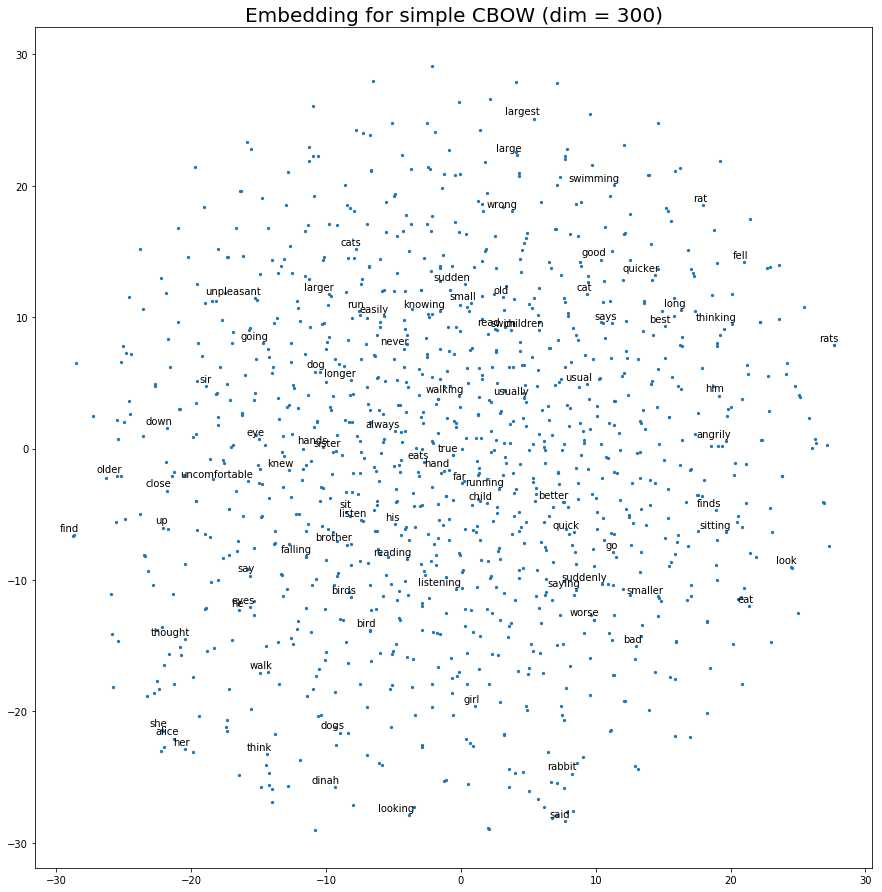

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.009s...
[t-SNE] Computed neighbors for 1183 samples in 0.787s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.133784
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.451424
[t-SNE] Error after 1000 iterations: 2.962834


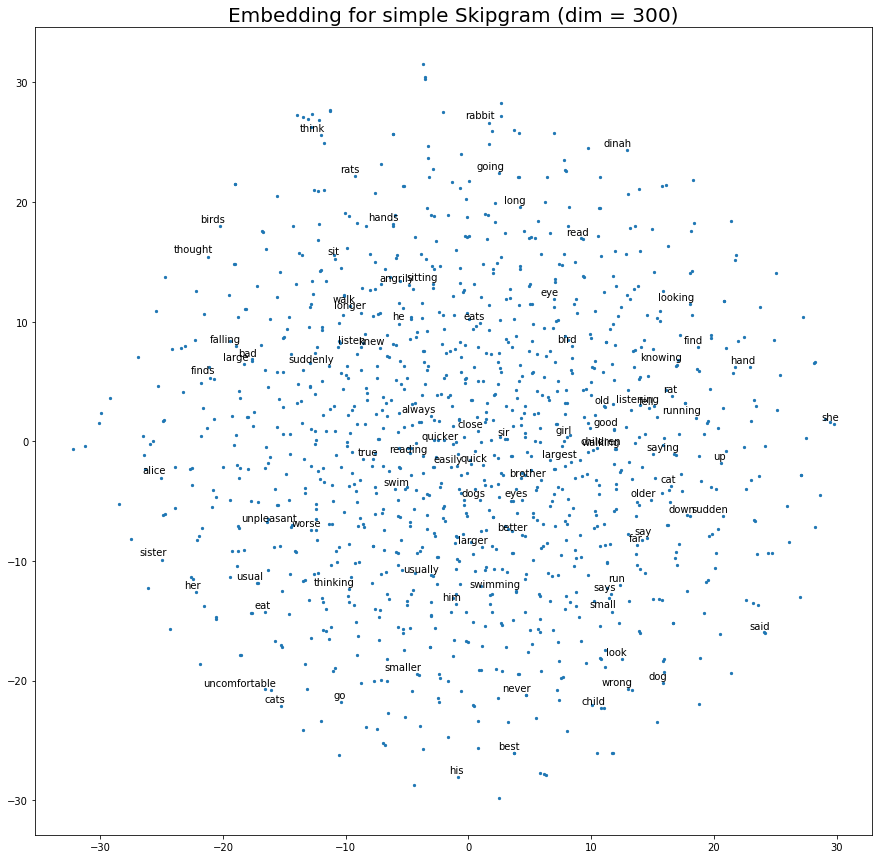

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.009s...
[t-SNE] Computed neighbors for 1183 samples in 1.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.103525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.087402
[t-SNE] Error after 1000 iterations: 2.956562


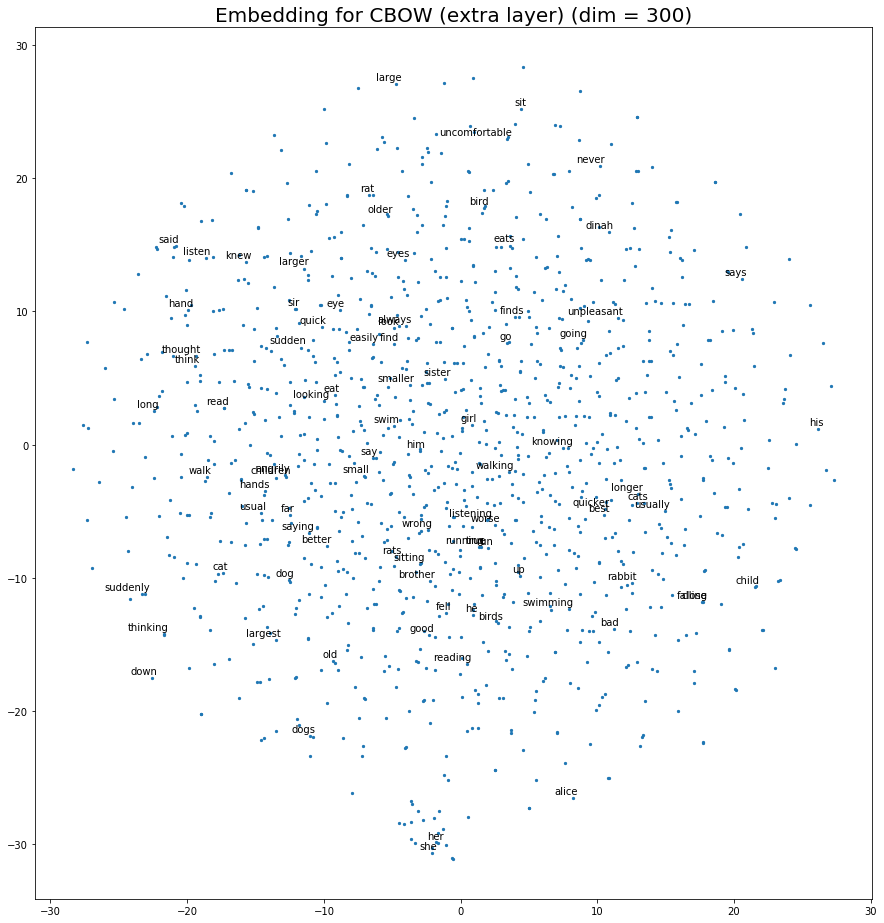

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.008s...
[t-SNE] Computed neighbors for 1183 samples in 0.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.131111
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.554520
[t-SNE] Error after 1000 iterations: 3.008010


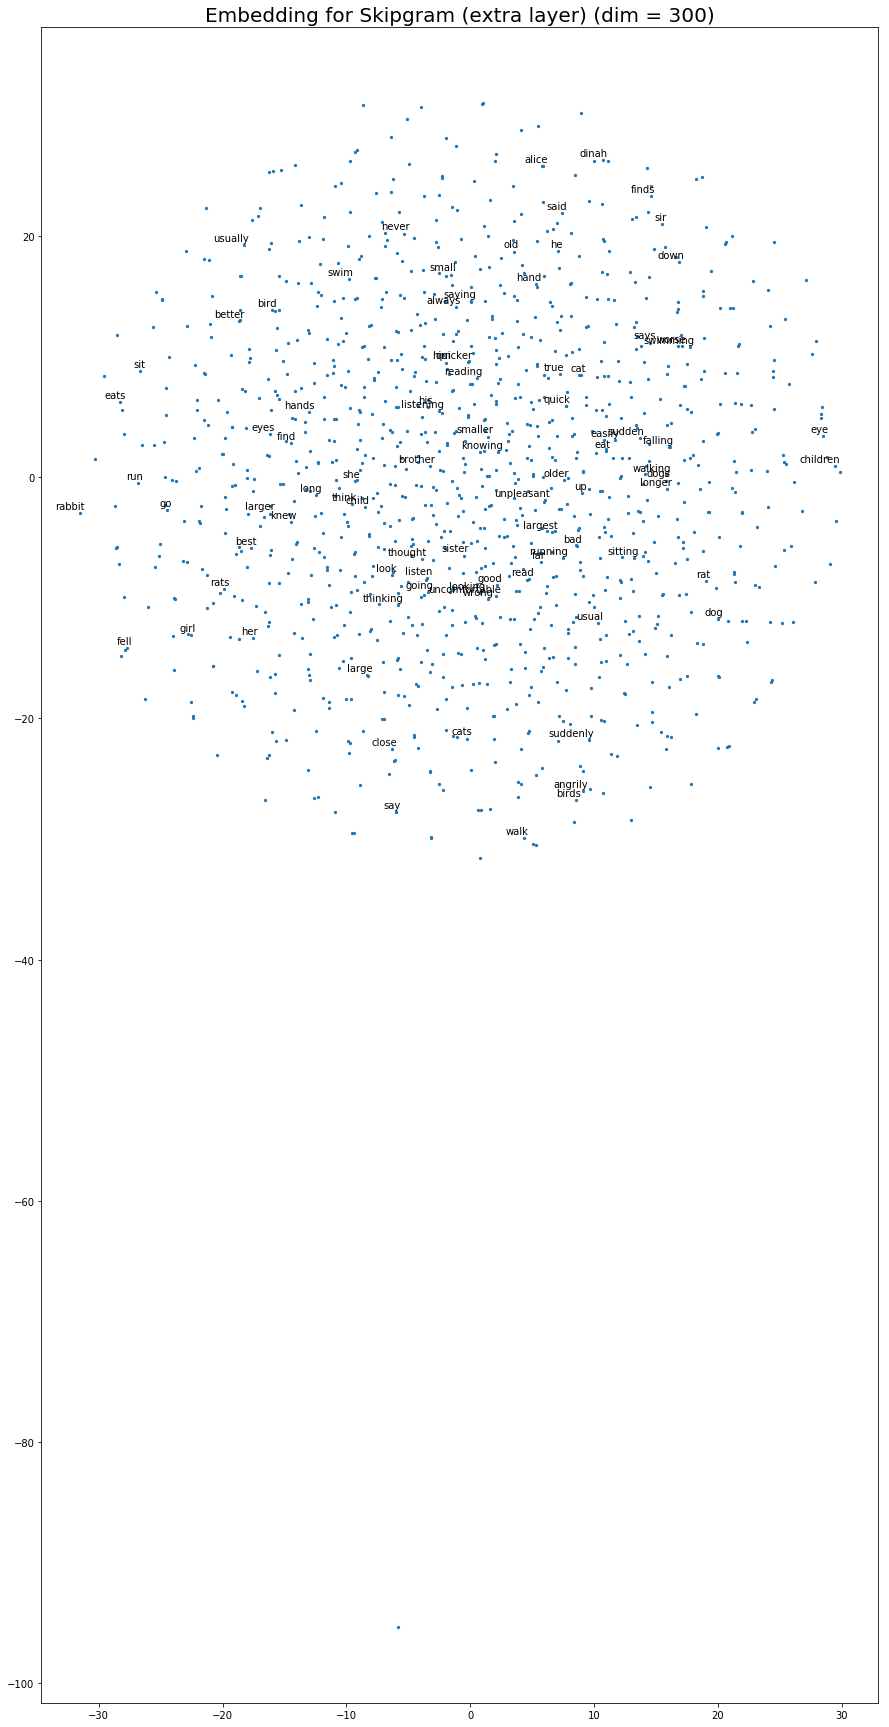

In [6]:
################################################################################
############ 4c. Visualize your results and interpret your results #############
################################################################################

# Get labels 
plot_labels = getLabels(full_index, True)
filter_labels = getAnalogyWords()

##################################### CBOW #####################################

# Transform data to 2d
weights = cbowWeights[len(cbowWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for simple CBOW (dim = 300)")


################################### Skipgram ###################################

# Transform data to 2d
weights = skipgramWeights[len(skipgramWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for simple Skipgram (dim = 300)")


############################## CBOW (extra layer) ##############################

# Transform data to 2d
weights = cbowHiddenLayerWeights[len(cbowHiddenLayerWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for CBOW (extra layer) (dim = 300)")


############################ Skipgram (extra layer) ############################

# Transform data to 2d
weights = skipgramHiddenLayerWeights[len(skipgramHiddenLayerWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for Skipgram (extra layer) (dim = 300)")



**Intepretation of results**

In this section we have presented the results for the iteration of `dim = 300` per algorithm, this is due to fact that we obtained the lowest loss with that model and additionally, it helps to make a fair comparison in Q7 with the 300-embedding of word2vec. The plots present only the labels of the words that are contained in the analogy file so it comes easier to make some findings, however the user can always change the labels that are shown by passing an argument to the plot function.

With respect to the analogy task, it can be observed that all of our algorithms obtained a bad result (0 matches) and usually they predicted the first or the last word in the analogy, instead of predicting the second one. This can be due to the approach of our analogy function (`wordA + wordD - wordC`) but it can also be explained by the representations on the plane for the four algorithms. For some cases we can see that, given an analogy `A is to B as C is to D`, going from A to B follows a different direction than going from C to D and furthermore the two distances differ too much. An example of such analogy is `go going look looking`. Although the reduction of dimensions can lead to loss of information in the plane, it already suggests that the embeddings of the words do not match the analogies presented since no clear groups can be found.

An additional reason might be that the relation of this words is not well modeled by the informantion that we obtain from the text and consequently they can not learn such analogies. As we will see in Q7, the rate is still poor even with a more robust embedding. 

An alternative to this evaluation can be the test of the embeddings on analogies coming from the book and with a pre prune of the words (example: stopwords) to improve the quality of the learning.


#### 5. Use the word-word co-occurrence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings

In [60]:
################################################################################
############# 5. Use the word co-occurence matrix from Question 1 ##############
############# Compare the performance on the analogy task.        ##############
################################################################################
    
nbrs = NearestNeighbors(n_neighbors = 1).fit(wcoMatrix)
analogyResultsWcoMatrix = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, wcoMatrix, full_index)
print("Score for w-w co-ocurrence matrix embedding: %s" % sum(analogyResultsWcoMatrix))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, usually)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, belong)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'alice she rabbit mouse' - (word, prediction) = (she, alice)
[False] 'good better quick quicker' - (word, prediction) = (better, good)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, knew)
[False] 'walk walking think thinking' - (word, prediction) = (w

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.038s...
[t-SNE] Computed neighbors for 1183 samples in 2.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.014133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.736832
[t-SNE] Error after 1000 iterations: 2.001384


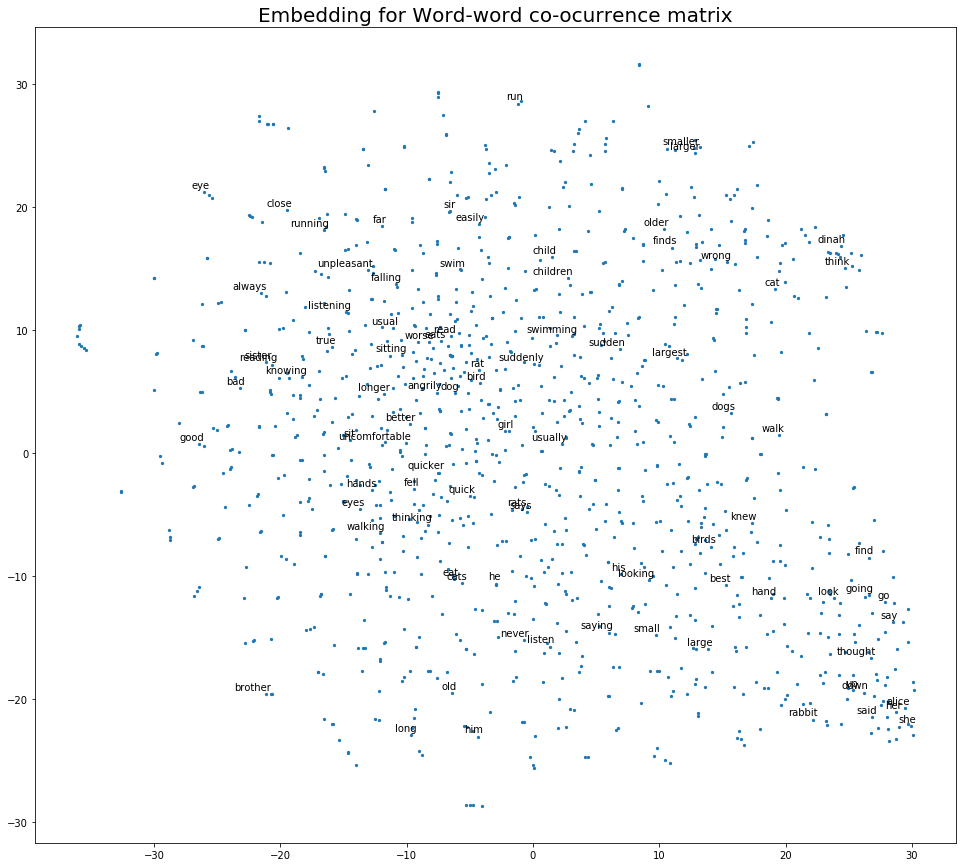

In [413]:
################################################################################
############# 5. Visualization of word co-occurence matrix from Q1 #############
################################################################################

import operator

# Get labels 
plot_labels = getLabels(full_index, True)
filter_labels = getAnalogyWords()


##################################### wwco #####################################

# Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(wcoMatrix)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for Word-word co-ocurrence matrix")



**Interpretation**

For this embedding we still have a very poor performance on the analogy task (score 0) but the plot shows some intuitive groups of words, for example `smaller-larger`, `child-children` or `he-she`. For the latter, it comes interesting to look at the analogy `he she his her` and visualize that although `her` and `she` are grouped together, that is not the case for `he` and `him`, which gives some intuition about the inability to match the analogy.


#### 6. Discuss

##### What are the main advantages of CBOW and Skipgram?

_General_

- Since both are distributed representations of words in a vector space, they help learning algorithms to achieve better performance in natural language processing tasks by grouping similar words.
- The word representations computed using neural networks encode many general linguistic regularities and patterns.

_CBOW_

- It requires less memory storage than skipgram.
- CBOW is also faster to train and works well with frequent words, this lies in the fact that CBOW is learning to predict the target word based on the context by maximizing the probability of this prediction. This is why CBOW works better with frequent words but not the same happens for rare words. For example, given the context `what a really [target] day`. The CBOW model will tell us that most probably the word is `beautiful` or `nice`, which are quite often used words. Words like `splendid` or `delightful` on the other hand will get much less attention in the model, because it is designed to predict the most probable word. 

_SKIPGRAM_

- The Skip Gram model can capture two semantics for a single word, like jaguar, one for the car company and another for the animal. 
- It is also more efficient with small training data and infrequent words are well presented in contrast with CBOW since the skip-gram is designed to predict the context based on the target word. In this case given the word `splendid` , which can be considered as a rare word, Skip-gram will study the corpus and respond with the most relevant context. So in the end the 2 words `nice` and `splendid` do not compete over the context since we treat `splendid+context` as a new observation.


##### What is the advantage of negative sampling?

Negative sampling tends to work better for frequent words and with low dimensional vectors. In the negative sampling method, every time a word is brought closer to its neighbors, a small number of other words randomly chosen are nudged/pushed away. Additionally, the fact that it uses just few random samples to distinguish the observed data from the artificially generated random noise, makes it really faster to sample the training data.

##### What are the main drawbacks of CBOW and Skipgram?

_CBOW_

CBOW takes the average of the context of a (target) word. For example, for the word `Apple` which can be both a fruit and a company CBOW takes an average of both the contexts and places it in between a cluster for fruits and companies. Thus we lose the meanings of polysemantic words.

_SKIPGRAM_

Skipgram takes a substantially larger amount of time since rather than averaging the context words, each context word is used as a pairwise training example. That is, in place of one CBOW example such as `predict 'ate' from average('The', 'cat', 'the', 'mouse')`, the network is presented with four skip-gram examples `[predict 'ate' from 'The'], [predict 'ate' from 'cat'], [predict 'ate' from 'the'], [predict 'ate' from 'mouse']`


#### 7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300

** Discussion**

For this section we have used the 300-embedding of the sets. It is important to mention that in this case, for the analogy task implementation we compute the neighbors based on the original space (word2vec function) since fitting a neighbours model with a subset of the original space can lead to incorrect conclusions. However, for the plotting we are just presenting the subset of words from our original vocabulary that are available in these two big sets. These details can be seen in detail in the code of the function of question 4.

With these embeddings we can see that the accuracy of the analogy task improved but we still have a low score(21% and 17%). If one takes a look at the analogies that were correctly answered it can be found that natural analogies such as `queen woman king man`, `boy girl man woman` or `his her he she` are matched, but still others like `pleasant pleasanter large larger`, `walk walking think thinking` are incorrectly assessed. This supports the suspicious that the analogies proposed are not easy to answer even with much more robust embeddings. 

Aditionally, it can also be observerd from the plots below that clearer groups can be found (example: `eat-eats`) which suggests a better modeling of the language from these datasets. 


##### - Google News

In [31]:
################################################################################
############## 7a. Load pre-trained embeddings on large corpuses  ##############
################################################################################

#load pretrained word embeddings of word2vec
path_word2vec = "./GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)


In [34]:
################################################################################
############# 7b. Performance on the analogy task Google-word2vec  #############
################################################################################

analogyResults = makeAnalogyOnFile(neighbors = None, embeddingType = EMBEDDING_TYPE_2, matrix = None, index = word2vec)

print("\nCount for GoogleNews embedding: %s" % (sum(analogyResults)))
print("Score for GoogleNews embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'happy unhappy pleasant unpleasant' - (word, prediction) = (unhappy, happy)
[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[True] 'he she his her' - (word, prediction) = (she, she)
[True] 'brother sister his her' - (word, prediction) = (sister, sister)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[True] 'bird birds cat cats' - (word, prediction) = (birds, birds)
[False] 'good better old older' - (word, prediction) = (better, good)
[True] 'good better quick quicker' - (word, prediction) = (better, better)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'happy unhappy comfortable uncomfortable' - (word, prediction) = (unhappy, happy)
[False] 'falling fell knowing 

Total of words included in Google index: 1157
Total of words not included in Google index: 25
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1157 samples in 0.014s...
[t-SNE] Computed neighbors for 1157 samples in 0.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1157
[t-SNE] Computed conditional probabilities for sample 1157 / 1157
[t-SNE] Mean sigma: 0.782791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.731049
[t-SNE] Error after 1000 iterations: 1.915029


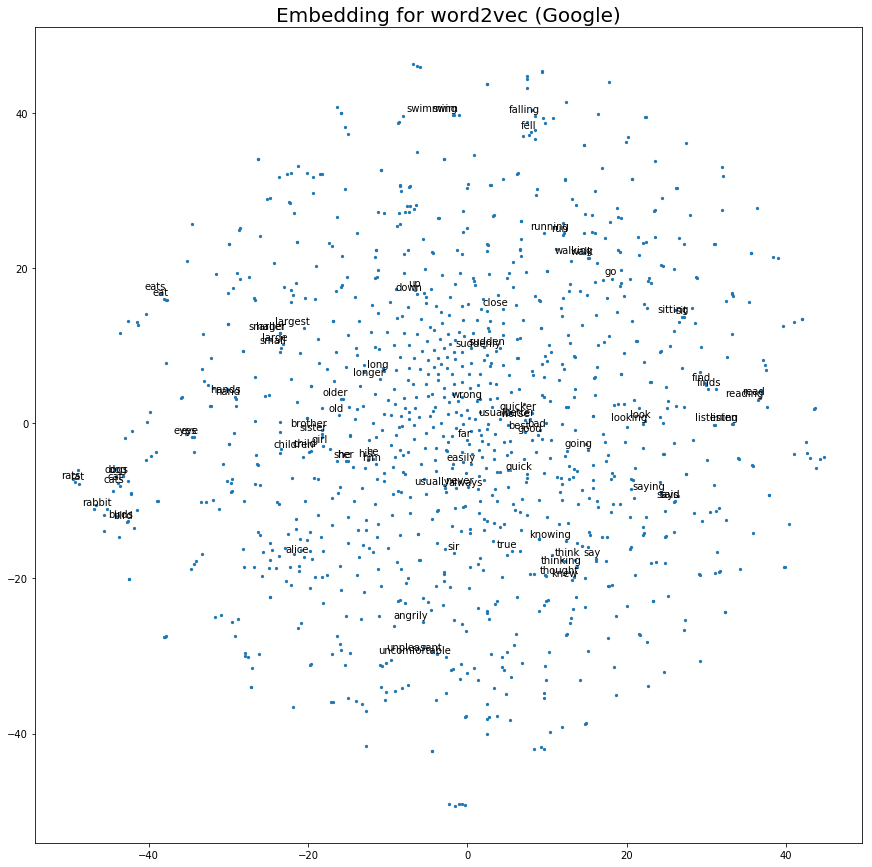

In [35]:
################################## GoogleNews ##################################

# Filtering only our vocabulary, otherwise it take way too long (never ending)
cT = 0
cF = 0
myGoogleIndex = dict()
myGoogleEmbeddings = []

counter = 0
for k, v in full_index.items():
    try: 
        value = word2vec.word_vec(k)
        myGoogleIndex[k] = counter
        myGoogleEmbeddings.append(value)
        cT += 1
        counter += 1
    except KeyError:
        cF +=1

myGoogleEmbeddings = np.asarray(myGoogleEmbeddings)

print("Total of words included in Google index:", cT)
print("Total of words not included in Google index:", cF)

###################### Visualize embeddings (word2vec) ######################

import operator

plot_labels = getLabels(myGoogleIndex)
filter_labels = getAnalogyWords()

#Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(myGoogleEmbeddings)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for word2vec (Google)")


##### - Glove

In [36]:
#load pretraind word embeddings of Glove

path = "./glove.6B/glove.6B.300d.txt"
path2 = "./glove_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path2, binary=False)


In [37]:
################################################################################
############## 7b. Performance on the analogy task Glove-word2vec ##############
################################################################################

analogyResults = makeAnalogyOnFile(neighbors = None, embeddingType = EMBEDDING_TYPE_2, matrix = None, index = glove)

print("\nCount for Glove embedding: %s" % (sum(analogyResults)))
print("Score for Glove embedding: %s" % (sum(analogyResults)/len(analogyResults)))



[False] 'happy unhappy pleasant unpleasant' - (word, prediction) = (unhappy, happy)
[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, bad)
[False] 'go going look looking' - (word, prediction) = (going, go)
[True] 'he she his her' - (word, prediction) = (she, she)
[True] 'brother sister his her' - (word, prediction) = (sister, sister)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[True] 'good better old older' - (word, prediction) = (better, better)
[True] 'good better quick quicker' - (word, prediction) = (better, better)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'happy unhappy comfortable uncomfortable' - (word, prediction) = (unhappy, happy)
[False] 'falling fell knowing kn

Total of words included in Glove index: 1173
Total of words not included in Glove index: 9
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1173 samples in 0.010s...
[t-SNE] Computed neighbors for 1173 samples in 1.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1173
[t-SNE] Computed conditional probabilities for sample 1173 / 1173
[t-SNE] Mean sigma: 1.710005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.954338
[t-SNE] Error after 1000 iterations: 1.837828


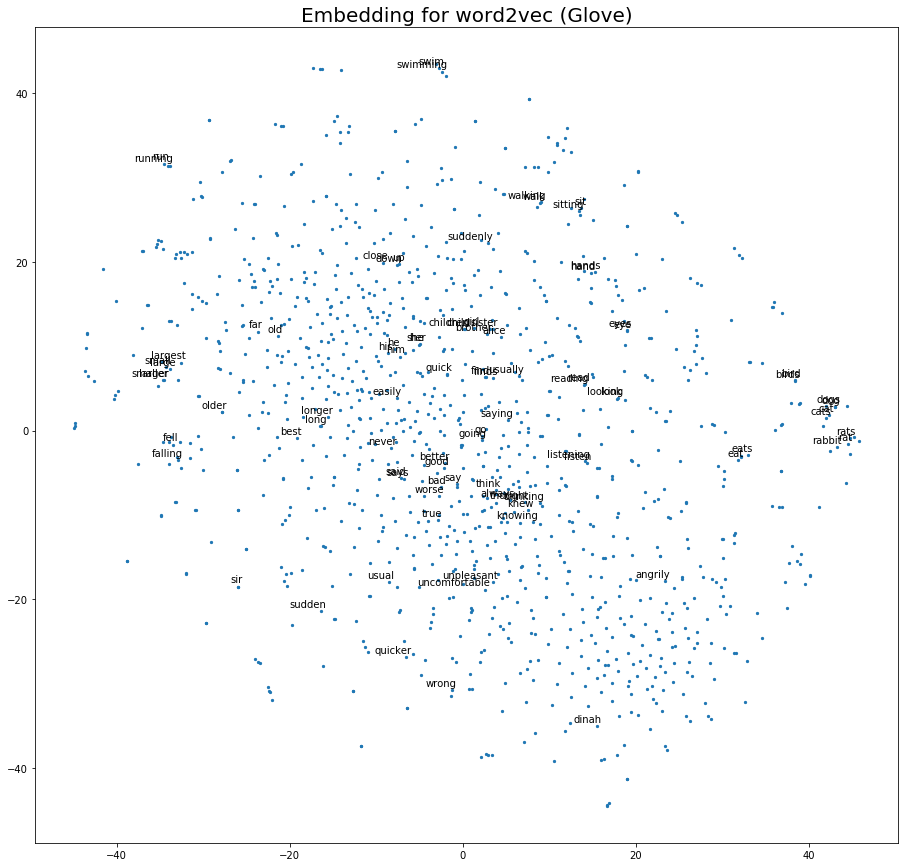

In [38]:
# Filtering only our vocabulary, otherwise it take way too long (never ending)

cT = 0
cF = 0
myGloveIndex = dict()
myGloveEmbeddings = []

counter = 0
for k, v in full_index.items():
    try: 
        value = glove.word_vec(k)
        myGloveIndex[k] = counter
        myGloveEmbeddings.append(value)
        cT += 1
        counter += 1
    except KeyError:
        cF +=1

myGloveEmbeddings = np.asarray(myGloveEmbeddings)


print("Total of words included in Glove index:", cT)
print("Total of words not included in Glove index:", cF)


###################### Visualize embeddings (word2vec) ######################

plot_labels = getLabels(myGloveIndex)

#Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(myGloveEmbeddings)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for word2vec (Glove)")


In [70]:
# Optional. Save the weight objects generated in this session for the NN
saveObject(cbowWeights, CBOW_WEIGHTS_FILE)
saveObject(skipgramWeights, SG_WEIGHTS_FILE)
saveObject(cbowHiddenLayerWeights, CBOW_HIDDEN_WEIGHTS_FILE)
saveObject(skipgramHiddenLayerWeights, SG_HIDDEN_WEIGHTS_FILE)